# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Mini-Projeto 4</font>
## <font color='blue'>Segmentação Automática de Imagens com SAM (Segment Anything Model)</font>

https://segment-anything.com/

![DSA](imagens/MP4.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.9


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/dmpm/Dropbox/DSA/DeepLearningPyTorch/Cap14/MP4


Instale Segment Anything Model (SAM) e outras dependências.

https://github.com/facebookresearch

In [4]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/home/dmpm/Dropbox/DSA/DeepLearningPyTorch/Cap14/MP4
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-p1njvwkd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-p1njvwkd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [5]:
# https://pypi.org/project/opencv-python/
!pip install -q opencv-python

In [6]:
# https://pypi.org/project/supervision/
!pip install -q supervision

In [7]:
# Imports
import torch
import torchvision
import cv2
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [8]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

cv2        : 4.8.0
supervision: 0.13.0
torch      : 2.0.1
sys        : 3.10.9 (main, Mar  1 2023, 18:23:06) [GCC 11.2.0]
torchvision: 0.15.2



### Download SAM Weights (Download do Modelo Pré-Treinado)

A célula abaixo precisa ser executada somente uma vez para download do modelo.

In [9]:
#%cd {HOME}/modelo
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [10]:
# Caminho onde está o modelo
caminho_modelo = os.path.join(HOME, "modelo", "sam_vit_h_4b8939.pth")

In [11]:
# Caminho onde está o modelo
print(caminho_modelo, "; exist:", os.path.isfile(caminho_modelo))

/home/dmpm/Dropbox/DSA/DeepLearningPyTorch/Cap14/MP4/modelo/sam_vit_h_4b8939.pth ; exist: True


## Carregando o Modelo

In [12]:
# Define o device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
print(f"Usando Device: {device}")

Usando Device: cuda:0


In [14]:
# Se CUDA estiver instalado imprimimos detalhes da GPU
if torch.cuda.is_available():
    print('Número de CUDA Devices:', torch.cuda.device_count())
    print('Modelo da GPU:', torch.cuda.get_device_name(0))
    print('Total de Memória [GB] da GPU:', torch.cuda.get_device_properties(0).total_memory/1e9)

Número de CUDA Devices: 1
Modelo da GPU: NVIDIA GeForce RTX 3080 Laptop GPU
Total de Memória [GB] da GPU: 8.361017344


In [15]:
# Tipo do modelo
tipo_modelo = "vit_h"

- vit_h = ViT Huge - https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
- vit_l = ViT Large - https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
- vit_b = ViT Base - https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [16]:
# Registra o modelo para uso nesta sessão do Jupyter Notebook
modelo_sam = sam_model_registry[tipo_modelo](checkpoint = caminho_modelo).to(device = device)

In [17]:
print(modelo_sam)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

## Geração Automatizada de Máscaras

Para executar a geração automática de máscaras, forneça um modelo SAM para a classe `SamAutomaticMaskGenerator`. Recomendado usar GPU.

In [18]:
# Cria o gerador automático de máscara
mask_generator = SamAutomaticMaskGenerator(modelo_sam)

In [19]:
# Imagens para segmentar
nome_imagem = "baleias.jpg"
#nome_imagem = "pessoas.jpg"
#nome_imagem = "frutas.png"
#nome_imagem = "carros1.jpg"
#nome_imagem = "carros2.jpg"
#nome_imagem = "carros3.jpg"
#nome_imagem = "brain1.jpg"
#nome_imagem = "brain2.png"
#nome_imagem = "lixo.png"
#nome_imagem = "fabrica1.jpg"
#nome_imagem = "fabrica2.jpeg"
#nome_imagem = "arvore.jpg"
#nome_imagem = "casa.jpg"

In [20]:
# Caminho da imagem
caminho_imagem = os.path.join(HOME, "dados", nome_imagem)

## Gerando Máscaras com SAM

In [21]:
# Carrega a imagem
imagem_bgr = cv2.imread(caminho_imagem)

In [22]:
# Converte o mapa de cores de BGR para RGB
imagem_rgb = cv2.cvtColor(imagem_bgr, cv2.COLOR_BGR2RGB)

In [23]:
# Gera as máscaras
resultado = mask_generator.generate(imagem_rgb)

In [24]:
print(resultado)

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 1043163, 'bbox': [0, 5, 1599, 891], 'predicted_iou': 1.0319057703018188, 'point_coords': [[525.0, 829.6875]], 'stability_score': 0.9820284247398376, 'crop_box': [0, 0, 1600, 900]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 249064, 'bbox': [142, 237, 896, 541], 'predicted_iou': 1.02549540996

In [25]:
# Vamos imprimir o resultado no índice zero
print(resultado[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


**Saída**:

SamAutomaticMaskGenerator() retorna uma lista de máscaras, onde cada máscara é um dicionário contendo várias informações:

* segmentation - `[np.ndarray]` - a máscara com shape `(W, H)` e tipo `bool` 
* area - `[int]` - a área da máscara em pixels
* bbox - `[List[int]]` - a caixa limite da máscara no formato `xywh`
* predicted_iou - `[float]` - a própria previsão do modelo para a qualidade da máscara
* point_coords - `[List[List[float]]]` - o ponto de entrada amostrado que gerou esta máscara
* stability_score - `[float]` - uma medida adicional da qualidade da máscara
* crop_box - `List[int]` - o recorte da imagem usada para gerar esta máscara no formato `xywh`

## Segmentando Objetos em Imagens de Forma Automática

Visualização de Resultados com Supervision

O Supervision possui suporte nativo para SAM.

In [26]:
# Cria o objeto 
mask_annotator = sv.MaskAnnotator()

In [27]:
# Extrai as máscaras detectadas com SAM
detections = sv.Detections.from_sam(sam_result = resultado)

In [28]:
len(detections)

17

In [29]:
# Busca as imagens anotadas. ATENÇÃO: Usamos aqui imagem_bgr
annotated_image = mask_annotator.annotate(scene = imagem_bgr.copy(), detections = detections)

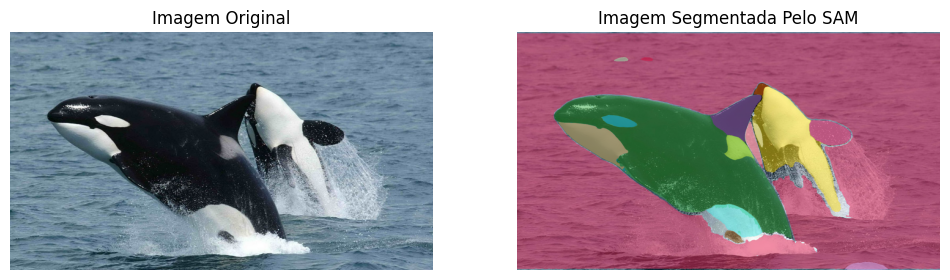

In [30]:
# Plot
sv.plot_images_grid(images = [imagem_bgr, annotated_image], 
                    grid_size = (1, 2), 
                    titles = ['Imagem Original', 'Imagem Segmentada Pelo SAM'])

## Visualizando as Máscaras Previstas Pelo SAM

In [31]:
# Extrai as máscaras
masks = [mask['segmentation'] for mask in sorted(resultado, key = lambda x: x['area'], reverse = True)]

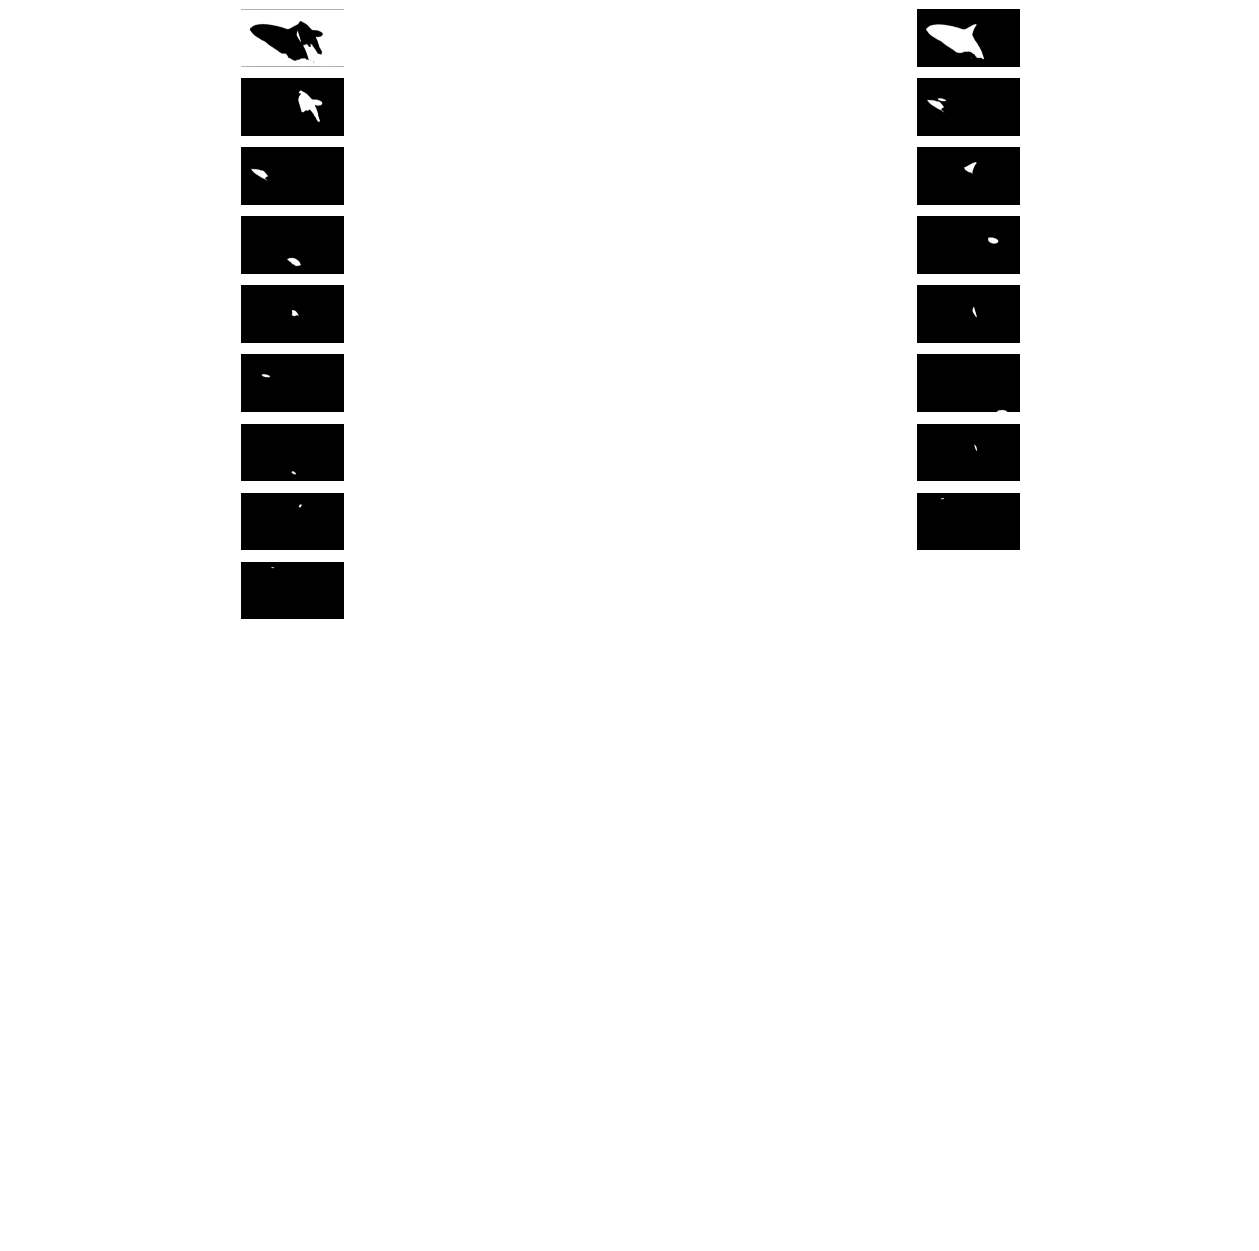

In [32]:
# Plot das máscaras previstas pelo SAM
sv.plot_images_grid(images = masks, grid_size = (18, int(len(masks) / 8)), size = (16, 16))

# Fim